# Testing Spark + `sparklyr`

## Uploading the data in JSON format 

First, we need to upload our data from our HOME to the HDFS home directory:

    $ hdfs dfs -put /mnt/gluster/...../data/jscars.json . 

## Install libraries in SparkR

Enter sparkR from your HOME:

    $ sparkR

Then, install the libraries as needed. When you finish, exit the interactive `sparkR` session.

    > install.packages()
    > q()

## Spark and R in Jupyter

### Configuring Spark and R 

Add this variable to .bashrc to avoid setting `Sys.setenv` in `R`.

    $ export R_PROFILE_USER=/usr/hdp/2.4.2.0-258/spark/R/lib/SparkR/profile/shell.R

In [20]:
# Sys.setenv(SPARK_HOME='/usr/hdp/2.4.2.0-258/spark') # commented after being added to .bashrc
.libPaths(c(file.path(Sys.getenv('SPARK_HOME'), 'R', 'lib'), .libPaths()))

# loading libraries
x <- c("sparklyr", "dplyr", "knitr", "ggplot2", "repr")
lapply(x, require, character.only = TRUE)

# Initiating spark context
sc <- spark_connect(master = "local", spark_home = "/usr/hdp/2.4.2.0-258/spark")

Loading required package: repr


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

Re-using existing Spark connection to local


### Reading JSON into Spark context

In [9]:
jscars <- spark_read_json(sc, name = "jscars", path = "jscars.json")

In [98]:
kable(head(jscars))



| am| carb| cyl| disp| drat| gear|  hp|  mpg|  qsec| vs|    wt|
|--:|----:|---:|----:|----:|----:|---:|----:|-----:|--:|-----:|
|  1|    4|   6|  160| 3.90|    4| 110| 21.0| 16.46|  0| 2.620|
|  1|    4|   6|  160| 3.90|    4| 110| 21.0| 17.02|  0| 2.875|
|  1|    1|   4|  108| 3.85|    4|  93| 22.8| 18.61|  1| 2.320|
|  0|    1|   6|  258| 3.08|    3| 110| 21.4| 19.44|  1| 3.215|
|  0|    2|   8|  360| 3.15|    3| 175| 18.7| 17.02|  0| 3.440|
|  0|    1|   6|  225| 2.76|    3| 105| 18.1| 20.22|  1| 3.460|

### Basic data wrangling

We can make good use of `magrittr::%>%` *pipes* for data wrangling or window operations:

In [95]:
jscars %>%
  group_by(vs) %>%
  filter(gear == 3, hp > 100) %>%
  mutate(horsepower_by_gear = rank(desc(hp / gear))) %>%
  mutate(mpg_rank = rank(mpg)) %>%
  select(gear, mpg_rank, horsepower_by_gear) %>% 
  head() %>%
  kable()

Warning message:
“Translator is missing window functions:
cor, count, cov, n_distinct, sd”Warning message:
“Translator is missing window functions:
cor, count, cov, n_distinct, sd”Warning message:
“Translator is missing window functions:
cor, count, cov, n_distinct, sd”Warning message:
“Translator is missing window functions:
cor, count, cov, n_distinct, sd”



| vs| gear| mpg_rank| horsepower_by_gear|
|--:|----:|--------:|------------------:|
|  0|    3|        1|                  4|
|  0|    3|        1|                  5|
|  0|    3|        3|                  1|
|  0|    3|        4|                  1|
|  0|    3|        5|                  3|
|  0|    3|        6|                  6|

### Graphs 

`geom_smooth()` using method = 'loess'


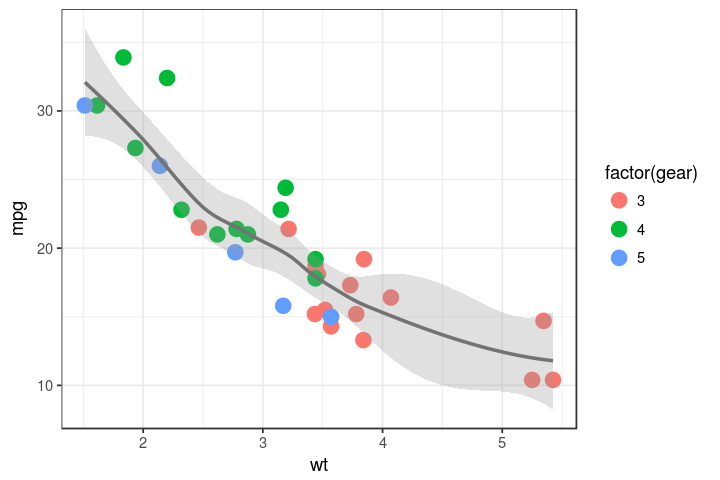

In [103]:
options(repr.plot.width=6, repr.plot.height=4)

jscars %>%
  collect() %>%
    ggplot(aes(wt, mpg)) +
    geom_point(aes(colour=factor(gear)), size=4) + 
    geom_smooth(colour="#737373", alpha=0.3) + 
    theme_bw()

### Models: K-means 

In [71]:
kmeans_model <- jscars %>%
  select(wt, mpg) %>%
  ml_kmeans(centers = 3)

print(kmeans_model)

* No rows dropped by 'na.omit' call


K-means clustering with 3 clusters

Cluster centers:
        wt      mpg
1 3.971714 14.95714
2 1.819600 30.88000
3 2.942308 21.46923

Within Set Sum of Squared Errors =  161.3099

In [101]:
# predict the associated class
predicts <- sdf_predict(kmeans_model, jscars) 
predicted <- collect(predicts)
kable(head(predicted))
base::table(predicted$am, predicted$prediction)



| am| carb| cyl| disp| drat| gear|  hp|  mpg|  qsec| vs|    wt| prediction|
|--:|----:|---:|----:|----:|----:|---:|----:|-----:|--:|-----:|----------:|
|  1|    4|   6|  160| 3.90|    4| 110| 21.0| 16.46|  0| 2.620|          2|
|  1|    4|   6|  160| 3.90|    4| 110| 21.0| 17.02|  0| 2.875|          2|
|  1|    1|   4|  108| 3.85|    4|  93| 22.8| 18.61|  1| 2.320|          2|
|  0|    1|   6|  258| 3.08|    3| 110| 21.4| 19.44|  1| 3.215|          2|
|  0|    2|   8|  360| 3.15|    3| 175| 18.7| 17.02|  0| 3.440|          2|
|  0|    1|   6|  225| 2.76|    3| 105| 18.1| 20.22|  1| 3.460|          0|

   
     0  1  2
  0 12  0  7
  1  2  5  6

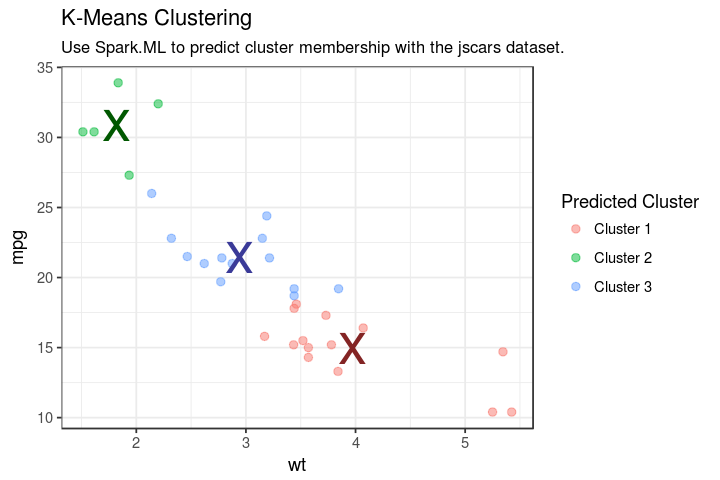

In [104]:
# plot cluster membership
sdf_predict(kmeans_model) %>%
  collect() %>%
  ggplot(aes(wt, mpg)) +
    geom_point(aes(wt, mpg, col = factor(prediction + 1)),
               size = 2, alpha = 0.5) + 
    geom_point(data = kmeans_model$centers, aes(wt, mpg),
               col = scales::muted(c("red", "green", "blue")),
               pch = 'x', size = 12) +
    scale_color_discrete(name = "Predicted Cluster",
                         labels = paste("Cluster", 1:3)) +
    labs(
      x = "wt",
      y = "mpg",
      title = "K-Means Clustering",
      subtitle = "Use Spark.ML to predict cluster membership with the jscars dataset."
    ) +
    theme_bw()

## Session 

### Paths recognised by sparkR 

In [29]:
# .libPaths()
# Sys.getenv("R_HOME")

### R session info

In [30]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

locale:
 [1] LC_CTYPE=es_ES.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=es_ES.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=es_ES.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] repr_0.10      ggplot2_2.2.0  knitr_1.15.1   dplyr_0.7.1    sparklyr_0.5.6
[6] SparkR_1.6.1  

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8      plyr_1.8.4       highr_0.6        dbplyr_1.1.0    
 [5] bindr_0.1        base64enc_0.1-3  tools_3.3.2      digest_0.6.10   
 [9] uuid_0.1-2       gtable_0.2.0     jsonlite_1.1     evaluate_0.10   
[13] tibble_1.3.3     pkgconfig_2.0.1  rlang_0

## References 

- [`sparklyr` tutorial](http://spark.rstudio.com/)
- [`sparklyr` cheatsheet](http://spark.rstudio.com/images/sparklyr-cheatsheet.pdf)
- [`sparklyr`: creating extensions](http://spark.rstudio.com/extensions.html)
- [Differences between `sparkr` and `sparklyr`](https://stackoverflow.com/questions/39494484/sparkr-vs-sparklyr)